In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import os
import sys

In [2]:
#setting hyper-paramter
data_iterations = 20
data_learning_rate = 0.08
data_num=1000
data_seed1=0
data_seed2=314
batch_size=800
epoch=200
activation='sigmoid'

In [3]:
#define the gradient descent optimization and record resutl at each step
def gradient_descent(x,y):
    m_curr = b_curr = 0
    n = len(x)
    log=[]
    for i in range(data_iterations):
        y_predicted = m_curr * x + b_curr
        cost = (1/n) * sum([val**2 for val in (y-y_predicted)])
        m_calc = -(2/n)*sum(x*(y-y_predicted))
        b_calc = -(2/n)*sum(y-y_predicted)
        m_curr = m_curr - data_learning_rate * m_calc
        b_curr = b_curr - data_learning_rate * b_calc
        log.append([m_curr,b_curr])
    return log

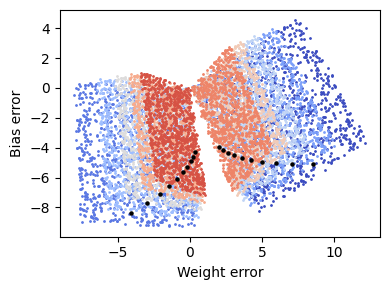

In [4]:
#create data size with gradient descent
x = np.arange(1,6)
np.random.seed(data_seed1)
w1=np.random.uniform(0,10,[data_num])
np.random.seed(data_seed2)
w2=np.random.uniform(0,10,[data_num])
data=np.stack((w1,w2)).T
log=[]
for i in range(data_num):
    y = x*w1[i]+w2[i]
    step=np.array(gradient_descent(x,y))
    log.append(step)
log=np.array(log)

#data visualization  
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(4,3),dpi=100)
cm=plt.cm.coolwarm
for i in range(10):
    plt.scatter(log[:,i,0]-w1,log[:,i,1]-w2,color=cm(i/10),s=1)
for i in range(data_iterations):
    plt.scatter(log[0,i,0]-w1[0],log[0,i,1]-w2[0],c='black',s=5)
    
plt.xlabel('Weight error')
plt.ylabel('Bias error')
plt.tight_layout()

In [5]:
#split data into training and testing set

index=np.arange(data_num)
np.random.seed(data_seed1)
np.random.shuffle(index)

x_train=log[index[int(data_num*0.2):],0]
x_test=log[index[:int(data_num*0.2)],0]
y_train=data[index[int(data_num*0.2):]]
y_test=data[index[:int(data_num*0.2)]]

#adopt last padding technique on dataset
aug=[]
for i in range(data_num):
    for j in range(10):
        temp=log[i,:(j+1)]
        aug.append(np.pad(temp, ((0,10-j-1),(0,0)), 'edge'))
aug_feature=np.array(aug)        
aug_data=np.repeat(data,10,axis=0)

aug_x_train=aug_feature.reshape(-1,10,10,2)[index[int(data_num*0.2):]].reshape(-1,10,2)
aug_x_test=aug_feature.reshape(-1,10,10,2)[index[:int(data_num*0.2)]][:,0].reshape(-1,10,2)
aug_y_train=aug_data.reshape(-1,10,2)[index[int(data_num*0.2):]].reshape(-1,2)
aug_y_test=aug_data.reshape(-1,10,2)[index[:int(data_num*0.2)]][:,0].reshape(-1,2)


In [6]:
#build model1 (conventional data process & ANN)
#build model2 (last padding data process & ANN)
#build model3 (last padding data process & CNN)

def gen_model1(shape):
    inp=keras.layers.Input(shape)
    h1=keras.layers.Dense(128,activation=activation)(inp)
    h1=keras.layers.BatchNormalization()(h1)
    h2=keras.layers.Dense(128,activation=activation)(h1)
    h2=keras.layers.BatchNormalization()(h2)
    out=keras.layers.Dense(2)(h2)
    model=keras.models.Model(inp,out)
    model.compile(loss='mse',optimizer='adam')
    return model
def gen_model2(shape):
    inp=keras.layers.Input(shape)
    inp2=keras.layers.Flatten()(inp)
    h1=keras.layers.Dense(128,activation=activation)(inp2)
    h1=keras.layers.BatchNormalization()(h1)
    h2=keras.layers.Dense(128,activation=activation)(h1)
    h2=keras.layers.BatchNormalization()(h2)
    out=keras.layers.Dense(2)(h2)
    model=keras.models.Model(inp,out)
    model.compile(loss='mse',optimizer='adam')
    return model
def gen_model3(shape):
    inp=keras.layers.Input(shape)
    c1=keras.layers.Conv1D(128,3,activation=activation,padding='causal')(inp)
    c2=keras.layers.Conv1D(128,3,activation=activation,padding='causal')(c1)
    g1=keras.layers.GlobalAveragePooling1D()(c2)
    g2=keras.layers.GlobalMaxPooling1D()(c2)
    out=keras.layers.Dense(2)(keras.layers.BatchNormalization()(keras.layers.add([g1,g2])))
    model=keras.models.Model(inp,out)
    model.compile(loss='mse',optimizer='adam')
    return model

In [7]:
keras.backend.clear_session()

model1=gen_model1([2])
model1.summary()
result1=model1.fit(x_train,y_train,
          batch_size=batch_size,
          epochs=epoch,validation_data=(x_test,y_test))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               384       
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 18,178
Trainable params: 17,666
Non-trainable params: 512
_______________________________________________________

Epoch 71/200
1/1 [==============================] - 0s 25ms/step - loss: 16.6081 - val_loss: 29.5387
Epoch 72/200
1/1 [==============================] - 0s 24ms/step - loss: 16.4344 - val_loss: 29.3175
Epoch 73/200
1/1 [==============================] - 0s 22ms/step - loss: 16.2588 - val_loss: 29.0952
Epoch 74/200
1/1 [==============================] - 0s 25ms/step - loss: 16.0815 - val_loss: 28.8648
Epoch 75/200
1/1 [==============================] - 0s 24ms/step - loss: 15.9025 - val_loss: 28.6281
Epoch 76/200
1/1 [==============================] - 0s 27ms/step - loss: 15.7218 - val_loss: 28.3946
Epoch 77/200
1/1 [==============================] - 0s 24ms/step - loss: 15.5395 - val_loss: 28.1639
Epoch 78/200
1/1 [==============================] - 0s 24ms/step - loss: 15.3557 - val_loss: 27.9289
Epoch 79/200
1/1 [==============================] - 0s 23ms/step - loss: 15.1703 - val_loss: 27.6927
Epoch 80/200
1/1 [==============================] - 0s 24ms/step - loss: 14.9834 - val_loss

1/1 [==============================] - 0s 26ms/step - loss: 2.3322 - val_loss: 11.4887
Epoch 153/200
1/1 [==============================] - 0s 29ms/step - loss: 2.2330 - val_loss: 11.3561
Epoch 154/200
1/1 [==============================] - 0s 25ms/step - loss: 2.1370 - val_loss: 11.2188
Epoch 155/200
1/1 [==============================] - 0s 25ms/step - loss: 2.0454 - val_loss: 11.1063
Epoch 156/200
1/1 [==============================] - 0s 28ms/step - loss: 1.9555 - val_loss: 10.9800
Epoch 157/200
1/1 [==============================] - 0s 26ms/step - loss: 1.8683 - val_loss: 10.8613
Epoch 158/200
1/1 [==============================] - 0s 28ms/step - loss: 1.7851 - val_loss: 10.7551
Epoch 159/200
1/1 [==============================] - 0s 28ms/step - loss: 1.7043 - val_loss: 10.6303
Epoch 160/200
1/1 [==============================] - 0s 27ms/step - loss: 1.6262 - val_loss: 10.5264
Epoch 161/200
1/1 [==============================] - 0s 24ms/step - loss: 1.5508 - val_loss: 10.4197
Epoc

In [8]:
keras.backend.clear_session()
model2=gen_model2([10,2])
model2.summary()
result2=model2.fit(aug_x_train,aug_y_train,
          batch_size=batch_size,
          epochs=epoch,validation_data=(aug_x_test,aug_y_test))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 2)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               2688      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258   

10/10 [==============================] - 0s 4ms/step - loss: 0.0481 - val_loss: 1.1143
Epoch 71/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0631 - val_loss: 1.7350
Epoch 72/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0748 - val_loss: 0.3706
Epoch 73/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0642 - val_loss: 1.9083
Epoch 74/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0702 - val_loss: 0.6902
Epoch 75/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0695 - val_loss: 0.7131
Epoch 76/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0617 - val_loss: 0.2462
Epoch 77/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0567 - val_loss: 0.9079
Epoch 78/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0509 - val_loss: 0.8479
Epoch 79/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0510 - val_loss: 0.5308
Epoch 80/200


10/10 [==============================] - 0s 4ms/step - loss: 0.0567 - val_loss: 0.0596
Epoch 152/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0227 - val_loss: 0.0685
Epoch 153/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0424 - val_loss: 1.2800
Epoch 154/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0501 - val_loss: 0.0848
Epoch 155/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0405 - val_loss: 0.0958
Epoch 156/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0268 - val_loss: 0.0953
Epoch 157/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0326 - val_loss: 0.0939
Epoch 158/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0265 - val_loss: 0.0277
Epoch 159/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0294 - val_loss: 0.0336
Epoch 160/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0417 - val_loss: 0.0516
Epoc

In [9]:
keras.backend.clear_session()

model3=gen_model3([10,2])
model3.summary()
result3=model3.fit(aug_x_train,aug_y_train,
          batch_size=batch_size,
          epochs=epoch,validation_data=(aug_x_test,aug_y_test))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 10, 128)      896         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 128)      49280       conv1d[0][0]                     
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 128)          0           conv1d_1[0][0]                   
______________________________________________________________________________________________

10/10 [==============================] - 0s 6ms/step - loss: 0.1339 - val_loss: 4.7758
Epoch 62/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1364 - val_loss: 3.9543
Epoch 63/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1284 - val_loss: 4.2920
Epoch 64/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1249 - val_loss: 4.9033
Epoch 65/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1207 - val_loss: 5.3122
Epoch 66/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1330 - val_loss: 3.9559
Epoch 67/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1268 - val_loss: 3.5782
Epoch 68/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1187 - val_loss: 3.4979
Epoch 69/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1201 - val_loss: 3.5224
Epoch 70/200
10/10 [==============================] - 0s 7ms/step - loss: 0.1296 - val_loss: 3.0233
Epoch 71/200


10/10 [==============================] - 0s 6ms/step - loss: 0.0225 - val_loss: 0.6052
Epoch 143/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.2613
Epoch 144/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0359 - val_loss: 2.2972
Epoch 145/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0469 - val_loss: 0.3644
Epoch 146/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0384 - val_loss: 0.2635
Epoch 147/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0354 - val_loss: 0.7487
Epoch 148/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0221 - val_loss: 1.2610
Epoch 149/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0277 - val_loss: 0.8957
Epoch 150/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0227 - val_loss: 0.5739
Epoch 151/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0167 - val_loss: 0.5905
Epoc

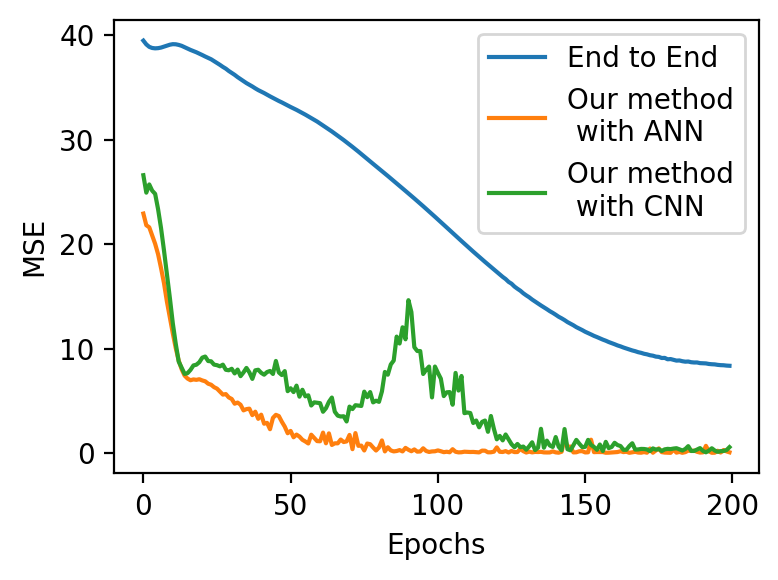

In [10]:
#show testing error difference between model1,2,3 
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(4,3),dpi=200)
plt.plot(result1.history["val_loss"],label='End to End')
plt.plot(result2.history["val_loss"],label='Our method\n with ANN')
plt.plot(result3.history["val_loss"],label='Our method\n with CNN')

plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend()
plt.tight_layout()